In [1]:
import numpy as np
# import sympy as symb
# from sympy import sin,cos
# from scipy.optimize import fsolve, root
import matplotlib.pyplot as plt
import copy

处理C问的V-cycle <br>
phi的迭代

In [2]:
def iter_phi(phi = np.zeros([64+1])):
    # 进行单步 G-S
    # k=4
    # N=64 # 64 grids 65 points
    N = phi.shape[0] - 1
    iter_num = 1 # only once   
    residual = np.zeros([N+1])
    delta = 1./(N)
    x_series = np.linspace(0,1,N+1)
    for j in range(1,N):
        # phi[t+1,j]=0.5*( phi[t,j+1] + phi[t+1,j-1] - delta**2*np.sin(k*np.pi*j*delta) )
        phi[j] = 0.5*(phi[j+1] + phi[j-1]) - 0.25*delta**2*( ( np.sin(16*np.pi*j*delta)+np.sin(np.pi*j*delta) ) )
    # add max residual max every iter #
    for j in range(1,N):
        residual[j] = 0.5*(np.sin(16*np.pi*j*delta)+np.sin(np.pi*j*delta) ) - (phi[j+1]-2*phi[j]+phi[j-1])/delta**2
    
    return phi,residual

error的迭代

In [3]:
def iter_error(residual = np.zeros([64+1])):
    # 进行单步 G-S
    # k=4
    # N=64 # 64 grids 65 points
    N = residual.shape[0] - 1
    iter_num = 1 # only once   
    error = np.zeros([N+1])
    error_residual = np.zeros([N+1])
    delta = 1./(N)
    x_series = np.linspace(0,1,N+1)
    for j in range(1,N):
        error[j] = 0.5*(error[j+1] + error[j-1]) - delta**2 * 0.5 * residual[j]
    # count residual
    for j in range(1,N):
        error_residual[j] = residual[j] - ( error[j+1] - 2*error[j] +error[j-1] )/delta**2
        # find max residual
        # residual_max[t+1]  = max( abs(residual[t+1,:]) )
    # phi[990,:]
    
    return error, error_residual

插值函数

In [4]:
def crouse(phi,factor=2):
    # finer[N=64] -> crouser[N=32]
    N = int( phi.shape[0] )
    need_dims = int( ( (phi.shape[0])-1 ) / factor )
    phi_new = np.zeros(need_dims+1)
    print("down -> new phi dimension is "+ str( phi_new.shape[0] )   )
    for j in range(1,need_dims):
        phi_new[j] = 0.25 * (phi[2*j-1] + 2*phi[2*j] + phi[2*j+1])
    
    # print(j)
    return phi_new

def fine(phi,factor=2):
    # crouser[N=32] -> finer[N=64] 
    N = int( phi.shape[0] )
    need_dims = int( ( (phi.shape[0])-1 ) * factor )
    phi_new = np.zeros(need_dims+1)
    print("up   -> new phi dimension is "+ str( phi_new.shape[0] )   )
    for j in range(0,N-1):
        phi_new[2*j]     = phi[j]
        phi_new[2*j + 1] = 0.5 * (phi[j] + phi[j+1])
    
    # print(j)
    return phi_new
# check error, during down and up (%)
# ( fine(crouse(gc()[0])) - gc()[0] )/ gc()[0]

In [5]:
def v_cycle_64_to_32(phi):
    # pre-smoothing
    phi64,residual_phi64 = iter_phi(phi)
    # if(shape)
    # down
    residual_phi32 = crouse(residual_phi64)
    # count error first step
    error32, residual_error32 = iter_error(residual_phi32)
    # 递归处理error32 - error16 - e8 -...-e2
    error32_new = v_cycle_32down(error32, residual_error32)
    # back to phi
    error64  = fine(error32_new)
    # add to phi
    phi_new = phi + error64
    # post-smoothing
    phi_new, residual_new = iter_phi(phi_new)

    return phi_new, residual_new



# v_cycle(phi_init)

In [6]:
def v_cycle_32down(error, error_residual):
    # 专门处理32往下的递归部分
    print("dims now: "+ str(error.shape[0]))
    if(error.shape[0]<=5):
        print("5->3 bottom!")
        residual_down = crouse(error_residual)
        error_new, residual_new = iter_error(residual_down)
#         print(error.shape)
#         print(error_new.shape)
        return_error = error + fine(error_new)
        print(return_error)
        return return_error
    

    # print("works")
    residual_down = crouse(error_residual)
    # crouse
    error_new, residual_new = iter_error(residual_down)
    # 递归，进行修正
    error_add = v_cycle_32down(error_new,residual_new)
    return_error = error + fine(error_add)
    print(return_error)
    return return_error


In [15]:
max(abs(r_test))

0.0010958913451361019

In [14]:
phi_test = np.zeros([64+1])
for i in range(0,7):
    phi_test,r_test = v_cycle_64_to_32(phi_test)

    


down -> new phi dimension is 33
dims now: 33
down -> new phi dimension is 17
dims now: 17
down -> new phi dimension is 9
dims now: 9
down -> new phi dimension is 5
dims now: 5
5->3 bottom!
down -> new phi dimension is 3
up   -> new phi dimension is 5
[ 0.         -0.02218902 -0.04199163 -0.02798809  0.        ]
up   -> new phi dimension is 9
[ 0.         -0.01263217 -0.02560357 -0.0372092  -0.04822543 -0.04148863
 -0.03381303 -0.01807384  0.        ]
up   -> new phi dimension is 17
[ 0.         -0.00641173 -0.01318189 -0.01980571 -0.02675348 -0.0326575
 -0.03884848 -0.04435627 -0.05013144 -0.04662895 -0.04338751 -0.03927517
 -0.03542924 -0.02716073 -0.01917419 -0.00965408  0.        ]
up   -> new phi dimension is 33
[ 0.         -0.00337832 -0.00650893 -0.00978119 -0.0133072  -0.01680698
 -0.02005782 -0.02342438 -0.02703776 -0.03017151 -0.03305316 -0.03602979
 -0.03925152 -0.04217254 -0.04484034 -0.04759242 -0.05058888 -0.04898686
 -0.04713126 -0.04535659 -0.0438263  -0.0419011  -0.039

/HGST_SATA_8T_3/yycheng/miniconda3/envs/from_WSL/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Unrecognized location 'lowerleft'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0.5, 1.0, 'residual by number of iterations')

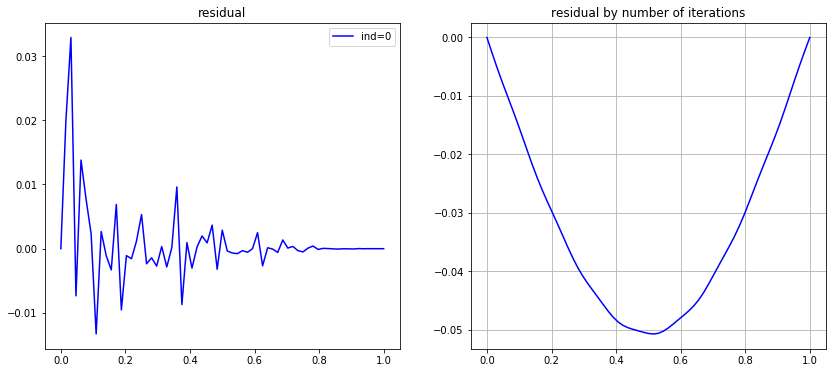

In [12]:
# plot center of domain
# series = u[0:ind_err,int((ny-1)/2),int((nz-1)/2)]

# import matplotlib.ticker as tck
fig,ax = plt.subplots(1,2,figsize=(14,6))
# custom_xlim = (0, np.p)
# custom_ylim = (0, 5.5)
# Setting the values for all axes.

# plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
# ax.set_xscale('log')
# stride = max( int(len(all_residual['1'][1:]) / 20), 1)
ax0=ax[0].plot(np.linspace(0,1,65), r_test[:],'-b', label='ind=0')
ax1=ax[1].plot(np.linspace(0,1,65), phi_test[:],'-b', label='ind=0')
# ax0=ax[0].plot(np.linspace(0,1,65), residual_b[10,:],'.-r', label='ind=10')
# ax0=ax[0].plot(np.linspace(0,1,65), residual_b[100,:],'x-g', label='ind=100')
# ax1=ax[1].plot(np.linspace(1,6,iter_num-2), r_test[1:-1],'-g', label='k=1')
# ax[1].set_yscale("log")
# ax[1].set_xlim([0,100])
# ax[1].set_xticks(np.linspace(0,100,11))
ax[1].grid()
# ax0=ax.plot(np.linspace(1,iter_num,iter_num-1), all_residual['2'][1:],'x-', label='k=2',markevery=stride)
# ax0=ax.plot(np.linspace(1,iter_num,iter_num-1), all_residual['4'][1:],'o-', label='k=4',markevery=stride)
# ax0=ax.plot(np.linspace(1,iter_num,iter_num-1), all_residual['8'][1:],'--', label='k=8')
# ax0=ax.plot(np.linspace(1,iter_num,iter_num-1), all_residual['16'][1:],'-', label='k=16')
# ax0=ax.plot(np.linspace(0,ind_err-1,ind_err-2), abs(series[0:-2] - series[1:-1]),'--g', label='')
# ax.set_yscale("log")
# ax.grid()
ax[0].legend(loc='lowerleft')
ax[0].set_title('residual')
ax[1].set_title('residual by number of iterations')
# ax[1].set_yscale("log")